In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
import graphviz
from sklearn.feature_selection import SelectKBest, f_classif
from xgboost import XGBClassifier
import dalex as dx

from funs import dataPreparation, evaluateModel

In [2]:
# Prepare the data
trxns_data = dataPreparation(all_trxns_path = "../all_trxns.csv", exchange_rates_path = "../exchange_rates.csv")

# Select the features
feature_names = ["customer_country", "counterparty_country", "type", "ccy", "customer_type", "weekday", "month", "quarter", "hour", "amount_eur_bucket"]

In [3]:
# Decision Tree - all features

# Split the data into training and testing sets
X = trxns_data[feature_names]

# Perform one-hot encoding
X_encoded = pd.get_dummies(X, columns=feature_names)

y = trxns_data['fraud_flag']
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

# Train a decision tree model
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

# Predict the fraud_flag for the testing set
y_pred = clf.predict(X_test)

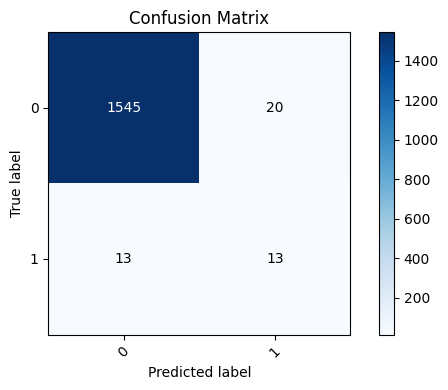


Accuracy: 97.93% 

              precision    recall  f1-score   support

           N       0.99      0.99      0.99      1565
           Y       0.39      0.50      0.44        26

    accuracy                           0.98      1591
   macro avg       0.69      0.74      0.72      1591
weighted avg       0.98      0.98      0.98      1591



In [5]:
# Decision Tree - all features - Performance Evaluation

evaluateModel(y_test, y_pred)

# the model is generally good, it has high accuracy but in the case of fraud detection it is not so accurate.
# it is very weak at detecting frauds, it has low recall and precision

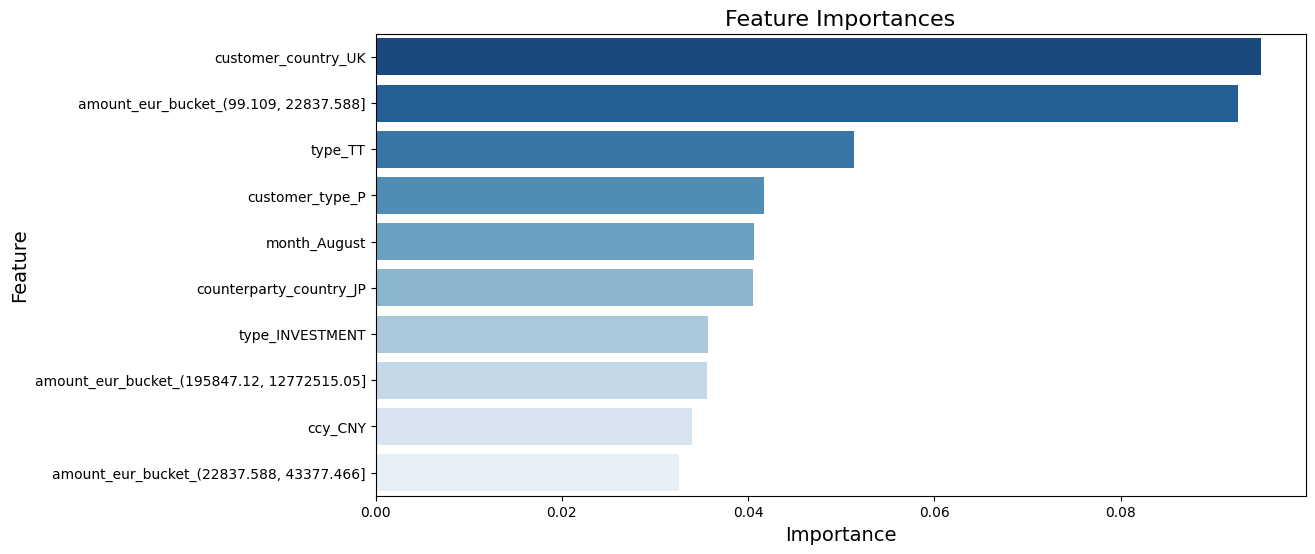

In [6]:
# Decision Tree - all features - Feature importances

importance_df = pd.DataFrame({'feature': X_train.columns, 'importance': clf.feature_importances_})
importance_df = importance_df.sort_values(by='importance', ascending=False)

# Filter out features with importance less than 0.03
importance_filtered = importance_df[importance_df['importance'] >= 0.03]

# Sort the filtered importance_df by importance
importance_filtered = importance_filtered.sort_values(by='importance', ascending=False)

# Create a barplot to display feature importances
plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=importance_filtered, palette='Blues_r')
plt.title('Feature Importances', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.show()

# from what i saw in the analysis i think this model is using wrong features

In [ ]:
# Decision Tree - all features - Plot the decision tree
# This is fun

dot_data = export_graphviz(clf, out_file=None, 
                           feature_names=X_encoded.columns,  
                           class_names=['Not Fraud', 'Fraud'],  
                           filled=True, rounded=True,  
                           special_characters=True)  
graph = graphviz.Source(dot_data)
graph.render("../fraud_detection_tree", format="png")

# Plot values interptetation
# 
# 'gini' is a measure of how often a randomly chosen element from the set would be incorrectly labeled if it were randomly labeled according to the distribution of labels in the subset. 
# The Gini index takes values between 0 and 1, where 0 represents a perfectly pure node, and 1 represents a perfectly impure node.
# 'samples' is the number of samples or transactions that are considered in each node of the tree, 
# 'value' is a list that shows the count of samples that belong to each class. For example, if the 'value' of a node is [30, 70], it means that there are 30 samples that belong to class 0, 
# and 70 samples that belong to class 1.

In [8]:
# Lets try the models with predefined features

# First would be ANOVA F-value selection

# Split the data into features (X) and target (y)
X = trxns_data[feature_names]
y = trxns_data['fraud_flag']

# Perform one-hot encoding
X_encoded = pd.get_dummies(X, columns=feature_names)

# Define the number of top features to select
k = 20

# Perform univariate feature selection using ANOVA F-value
selector = SelectKBest(f_classif, k=k)
selector.fit(X_encoded, y)

# Get the scores and p-values of each feature
scores = selector.scores_
pvalues = selector.pvalues_

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'feature': X_encoded.columns,
    'score': scores,
    'pvalue': pvalues
})

# Sort the results by score in descending order
results_df = results_df.sort_values(by='score', ascending=False)

# Get only the most significant features (p-value <= 0.01)
results_df = results_df[results_df['pvalue'] <= 0.01]

In [9]:
# Decision Tree - selected features

# Split the data into training and testing sets
X_selected = X_encoded[results_df['feature']]

y = trxns_data['fraud_flag']
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)

# Train a decision tree model
clf_selected = DecisionTreeClassifier()
clf_selected.fit(X_train, y_train)

# Predict the fraud_flag for the testing set
y_pred = clf_selected.predict(X_test)

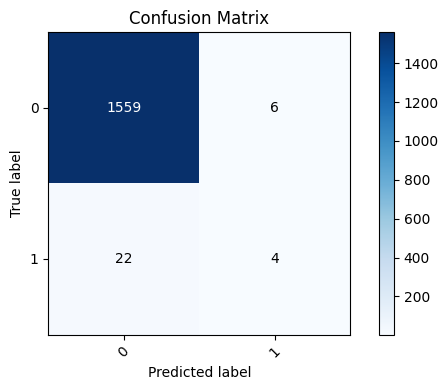


Accuracy: 98.24% 

              precision    recall  f1-score   support

           N       0.99      1.00      0.99      1565
           Y       0.40      0.15      0.22        26

    accuracy                           0.98      1591
   macro avg       0.69      0.58      0.61      1591
weighted avg       0.98      0.98      0.98      1591



In [11]:
evaluateModel(y_test, y_pred)

# It is even worse...

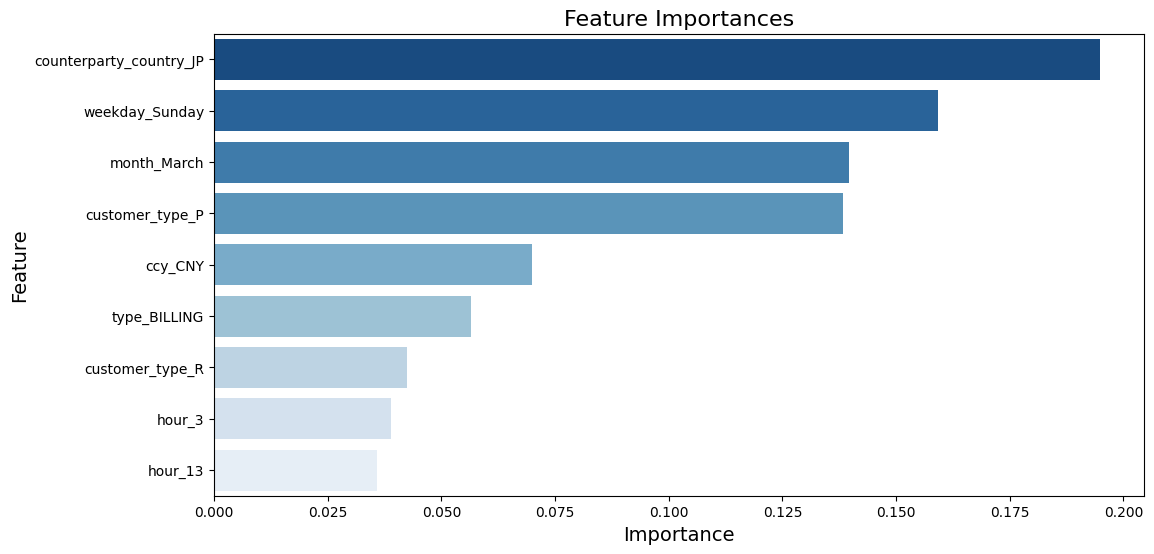

In [12]:
# Decision Tree - selected features - Get feature importances
importance_df = pd.DataFrame({'feature': X_train.columns, 'importance': clf_selected.feature_importances_})
importance_df = importance_df.sort_values(by='importance', ascending=False)

# Filter out features with importance less than 0.03
importance_filtered = importance_df[importance_df['importance'] >= 0.03]

# Sort the filtered importance_df by importance
importance_filtered = importance_filtered.sort_values(by='importance', ascending=False)

# Create a barplot to display feature importances
plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=importance_filtered, palette='Blues_r')
plt.title('Feature Importances', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.show()

# i think the features are better, but i might be wrong

In [ ]:
# Decision Tree - selected features - Plot the decision tree
# Still fun

dot_data_selected = export_graphviz(clf_selected, out_file=None, 
                           feature_names=X_selected.columns,  
                           class_names=['Not Fraud', 'Fraud'],  
                           filled=True, rounded=True,  
                           special_characters=True)  
graph = graphviz.Source(dot_data_selected)
graph.render("../fraud_detection_tree_selected", format="png")

In [13]:
# Lets try the models with predefined features

# Now i will try my own features
my_feature_names = ["type_BILLING", "type_DIVIDEND", "type_INTEREST", "type_INVESTMENT", "type_PAYMENT", 
                    "ccy_CNY", "quarter_Q2", "hour_13", "customer_type_C", "customer_type_P", 
                    "weekday_Sunday", "month_June", "month_March", "month_November"]

# Split the data into features (X) and target (y)
X = trxns_data[feature_names]
y = trxns_data['fraud_flag']

# Perform one-hot encoding
X_encoded = pd.get_dummies(X, columns=feature_names)
X_encoded = X_encoded[my_feature_names]

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

# Train a decision tree model
clf_selected = DecisionTreeClassifier()
clf_selected.fit(X_train, y_train)

# Predict the fraud_flag for the testing set
y_pred = clf_selected.predict(X_test)

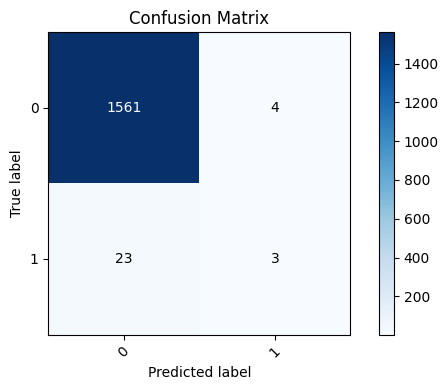


Accuracy: 98.30% 

              precision    recall  f1-score   support

           N       0.99      1.00      0.99      1565
           Y       0.43      0.12      0.18        26

    accuracy                           0.98      1591
   macro avg       0.71      0.56      0.59      1591
weighted avg       0.98      0.98      0.98      1591



In [15]:
evaluateModel(y_test, y_pred)

# Not the best approach to use decision tree, but it is fun
# I will try decision tree on steroids

In [16]:
# XGBoost - all features

# prepare copied set

trxns_data_copy = trxns_data.copy()

# Convert values in 'fraud_flag' column to binary format
trxns_data_copy['fraud_flag'] = trxns_data_copy['fraud_flag'].replace({'N': 0, 'Y': 1})

# Split the data into training and testing sets
X = trxns_data_copy[feature_names]
y = trxns_data_copy['fraud_flag']

# Perform one-hot encoding
X_encoded = pd.get_dummies(X, columns=feature_names)

# Rename feature columns to remove brackets
X_encoded.columns = [col.replace('[', '').replace(']', '') for col in X_encoded.columns]

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42, stratify=y)

# If the feature selection is required, uncomment the following lines
# selector = SelectKBest(f_classif, k=10)
# selector.fit(X_train, y_train)
# X_train = selector.transform(X_train)
# X_test = selector.transform(X_test)

# Train an XGBoost model
# https://xgboost.readthedocs.io/en/stable/parameter.html
model_xgb = XGBClassifier(learning_rate= 1, eta = .8, n_estimators=500, max_depth=5, random_state=42)
model_xgb.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model_xgb.predict(X_test)

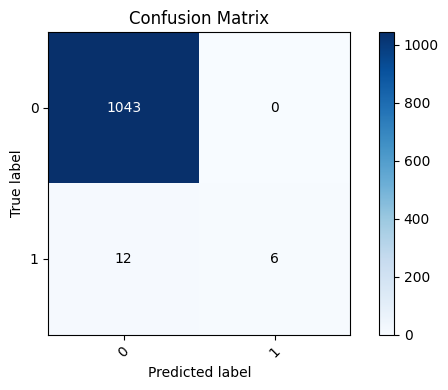


Accuracy: 98.87% 

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1043
           1       1.00      0.33      0.50        18

    accuracy                           0.99      1061
   macro avg       0.99      0.67      0.75      1061
weighted avg       0.99      0.99      0.99      1061



In [18]:
evaluateModel(y_test, y_pred)

# well, it is better than decision tree
# but still not good
# tuning could help but i think more helpful would be to get more data to train the model

In [19]:
# Explainable AI

# This is very interesting how much information we can extract from the model

# create explainer using DALEX package
explainer = dx.Explainer(model_xgb, X_train, y_train)

# calculate partial dependence plot for a selected feature
pdp = explainer.model_profile(type = "partial", variables = "hour_13")

Preparation of a new explainer is initiated

  -> data              : 4241 rows 87 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 4241 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x0000024EF4E77130> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 1.68e-10, mean = 0.0172, max = 0.999
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.198, mean = 3.65e-07, max = 0.216
  -> model_info        : package xgboost

A new explainer has been created!


Calculating ceteris paribus: 100%|██████████| 1/1 [00:00<00:00, 15.05it/s]


In [20]:
# calculate SHAP values
shap_values = explainer.predict(X_test)

In [21]:
# Understand which features are most important

explainer.model_parts().plot()

In [22]:
# Understand the impact of each feature on the model output

# this will be a lot of scrolling but its interesting

explainer.model_profile().plot()

Calculating ceteris paribus: 100%|██████████| 87/87 [00:06<00:00, 14.48it/s]


In [23]:
# Calculate shapley values for a single observation
instance = X_test.iloc[0]
instance

customer_country_SG                          0
customer_country_UK                          1
customer_country_US                          0
counterparty_country_BR                      0
counterparty_country_CN                      0
                                            ..
amount_eur_bucket_(99.109, 22837.588         1
amount_eur_bucket_(22837.588, 43377.466      0
amount_eur_bucket_(43377.466, 62376.65       0
amount_eur_bucket_(62376.65, 195847.12       0
amount_eur_bucket_(195847.12, 12772515.05    0
Name: 2751, Length: 87, dtype: uint8

In [24]:
shap_values = explainer.predict_parts(instance)

# Ceteris paribus plot for a single observation
# cp_values = explainer.predict_profile(instance)

In [25]:
# Why the model thinks the probability of fraud is somwhere between 0.015 and 0.02

shap_values.plot()

In [ ]:
# In conclusion i think that the model is not good enough to be used in production
# but it is a good start to understand the data and the problem
# for sure more data would help to improve the model
# there are many other models that could be used
# for example random forest, logistic regression, neural networks, support vector machines
# but i would like to try different approach
# look at Linear Programming Model